In [ ]:
 !pip install gym stable-baselines3 optuna pandas numpy matplotlib shimmy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import gym
from gym import spaces
import random, itertools
import optuna
import matplotlib.pyplot as plt
from stable_baselines3 import DQN       # SB3’s DQN uses Double Q‐learning internally
from stable_baselines3.common.evaluation import evaluate_policy

# 2) Load & preprocess data

In [ ]:
df = pd.read_csv('/content/raw_data.csv', parse_dates=['date'], index_col='date')
df['hvac_energy'] = (df['Appliances'] - df['lights']).clip(lower=0)

# 3) Train/test split (70% train, 30% test)
split_idx = int(0.7 * len(df))
train_df = df.iloc[:split_idx].reset_index(drop=True)
test_df  = df.iloc[split_idx:].reset_index(drop=True)

# 4) Custom HVAC Gym environment (per your report)

In [ ]:
class HVACEnv(gym.Env):
    def __init__(self, data, desired_temp=22.0, lam=0.1):
        super().__init__()
        self.df = data
        self.desired_temp = desired_temp
        self.lam = lam
        self.action_space = spaces.Discrete(4)  # Off, Low, Medium, High

        low  = np.array([
            data[['T1','T2','T3','T4','T5','T6','T7','T8','T9']].min().min(),
            data['T_out'].min(), 0, 0
        ], dtype=np.float32)
        high = np.array([
            data[['T1','T2','T3','T4','T5','T6','T7','T8','T9']].max().max(),
            data['T_out'].max(), 1, 23
        ], dtype=np.float32)
        self.observation_space = spaces.Box(low, high, dtype=np.float32)

        # percentile thresholds
        self.thresholds = np.percentile(data['hvac_energy'], [0,25,50,75])
        self.reset()

    def reset(self):
        self.idx = 0
        return self._get_obs()

    def _get_obs(self):
        row = self.df.iloc[self.idx]
        avg_in = row[['T1','T2','T3','T4','T5','T6','T7','T8','T9']].mean()
        out    = row['T_out']
        occ    = float(row['lights'] > 0)
        hr     = self.idx % 24
        return np.array([avg_in, out, occ, hr], dtype=np.float32)

    def step(self, action):
        energy   = float(self.thresholds[action])
        comfort  = abs(self._get_obs()[0] - self.desired_temp)
        reward   = -(energy + self.lam * comfort)
        self.idx += 1
        done     = (self.idx >= len(self.df))
        obs      = self._get_obs() if not done else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, done, {}

# 5) Train & evaluate helper

In [ ]:
def train_and_eval_ddqn(env, params, train_steps=50_000, eval_eps=5):
    model = DQN(
        'MlpPolicy', env,
        gamma=params['gamma'],
        learning_rate=params['learning_rate'],
        buffer_size=int(params['buffer_size']),
        batch_size=int(params['batch_size']),
        train_freq=int(params['train_freq']),
        verbose=0
    )
    model.learn(total_timesteps=train_steps)
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=eval_eps)
    return mean_reward

# 6) Hyperparameter search routines

In [ ]:
def random_search_ddqn(env, n_trials=8):
    best = {'score': -np.inf, 'params': None}
    for _ in range(n_trials):
        p = {
            'gamma': random.choice([0.9, 0.95, 0.99]),
            'learning_rate': 10**random.uniform(-5, -3),
            'buffer_size': random.choice([5_000, 10_000, 20_000]),
            'batch_size': random.choice([32, 64, 128]),
            'train_freq': random.choice([4, 8, 16])
        }
        s = train_and_eval_ddqn(env, p)
        if s > best['score']:
            best = {'score': s, 'params': p}
    return best

def grid_search_ddqn(env):
    grid = {
        'gamma': [0.9, 0.95],
        'learning_rate': [1e-5, 1e-4],
        'buffer_size': [5_000, 10_000],
        'batch_size': [32, 64],
        'train_freq': [4, 8]
    }
    best = {'score': -np.inf, 'params': None}
    for combo in itertools.product(*grid.values()):
        p = dict(zip(grid.keys(), combo))
        s = train_and_eval_ddqn(env, p)
        if s > best['score']:
            best = {'score': s, 'params': p}
    return best

def bayesian_search_ddqn(env, n_trials=12):
    def objective(trial):
        p = {
            'gamma': trial.suggest_categorical('gamma', [0.9, 0.95, 0.99]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
            'buffer_size': trial.suggest_categorical('buffer_size', [5_000, 10_000, 20_000]),
            'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
            'train_freq': trial.suggest_categorical('train_freq', [4, 8, 16])
        }
        return train_and_eval_ddqn(env, p)
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    return {'score': study.best_value, 'params': study.best_params}

# 7) Run hyperparameter tuning

In [ ]:
env_train = HVACEnv(train_df)
best_rand = random_search_ddqn(env_train)
best_grid = grid_search_ddqn(env_train)
best_bayes= bayesian_search_ddqn(env_train)

print("Random Search best:", best_rand)
print("Grid Search best:  ", best_grid)
print("Bayesian best:     ", best_bayes)

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment f

Random Search best: {'score': np.float64(-4896.012100683547), 'params': {'gamma': 0.99, 'learning_rate': 5.880657696988699e-05, 'buffer_size': 20000, 'batch_size': 64, 'train_freq': 16}}
Grid Search best:   {'score': np.float64(-4896.012100683547), 'params': {'gamma': 0.9, 'learning_rate': 1e-05, 'buffer_size': 5000, 'batch_size': 32, 'train_freq': 4}}
Bayesian best:      {'score': -4896.012100683547, 'params': {'gamma': 0.9, 'learning_rate': 5.666178725335688e-05, 'buffer_size': 10000, 'batch_size': 64, 'train_freq': 4}}


# 8) Train final DDQN with best Bayesian params

In [ ]:
p = best_bayes['params']
model_ddqn = DQN(
    'MlpPolicy', env_train,
    gamma=p['gamma'],
    learning_rate=p['learning_rate'],
    buffer_size=int(p['buffer_size']),
    batch_size=int(p['batch_size']),
    train_freq=int(p['train_freq']),
    verbose=1
)
model_ddqn.learn(total_timesteps=50_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


# 9) Evaluate & compute savings

In [ ]:
env_test   = HVACEnv(test_df)
baseline_wh= test_df['hvac_energy'].sum()

obs, done, rl_wh = env_test.reset(), False, 0.0
while not done:
    action, _ = model_ddqn.predict(obs, deterministic=True)
    obs, _, done, _ = env_test.step(action)
    rl_wh    += env_test.thresholds[action]

energy_savings = baseline_wh - rl_wh
cost_savings   = energy_savings * (0.12 / 1000)  # $ per Wh

# 10) Plot savings

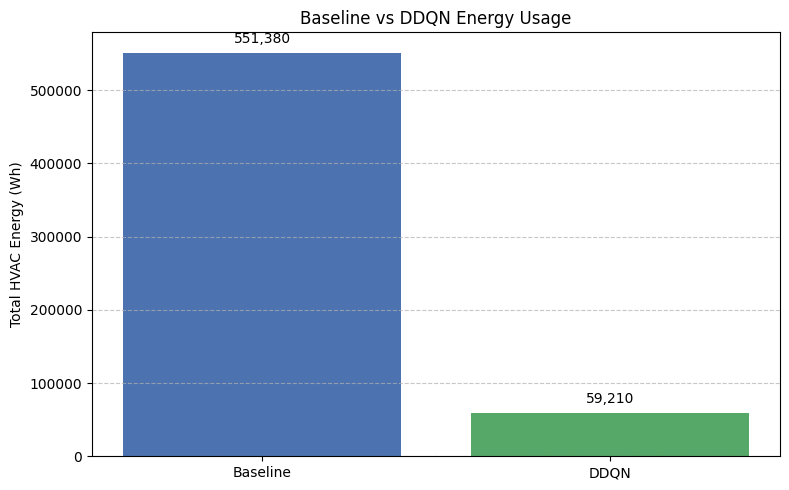

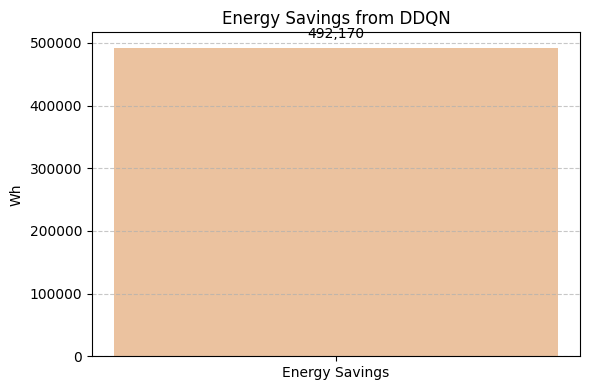

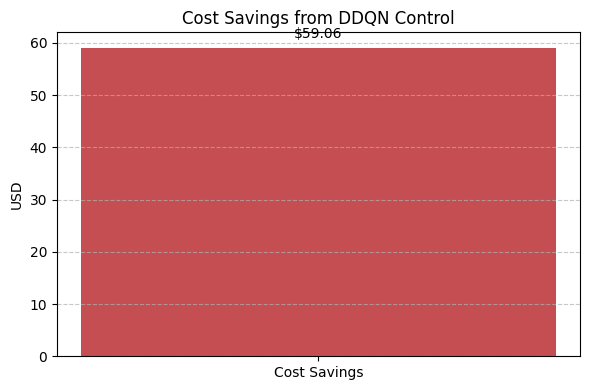

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(['Baseline','DDQN'], [baseline_wh, rl_wh], color=['#4c72b0','#55a868'])
ax.set_ylabel('Total HVAC Energy (Wh)')
ax.set_title('Baseline vs DDQN Energy Usage')
ax.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    ax.annotate(f'{bar.get_height():,.0f}',
                xy=(bar.get_x()+bar.get_width()/2, bar.get_height()),
                xytext=(0,5), textcoords='offset points',
                ha='center', va='bottom')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(['Energy Savings'], [energy_savings], color='#ebc29f')
ax.set_ylabel('Wh')
ax.set_title('Energy Savings from DDQN')
ax.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    ax.annotate(f'{bar.get_height():,.0f}',
                xy=(bar.get_x()+bar.get_width()/2, bar.get_height()),
                xytext=(0,5), textcoords='offset points',
                ha='center', va='bottom')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(['Cost Savings'], [cost_savings], color='#c44e52')
ax.set_ylabel('USD')
ax.set_title('Cost Savings from DDQN Control')
ax.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    ax.annotate(f'${bar.get_height():,.2f}',
                xy=(bar.get_x()+bar.get_width()/2, bar.get_height()),
                xytext=(0,5), textcoords='offset points',
                ha='center', va='bottom')
plt.tight_layout()
plt.show()

Average Baseline Temperature Deviation: 1.69 °C
Average DDQN Temperature Deviation: 1.69 °C
Temperature Deviation Improvement: 0.00%


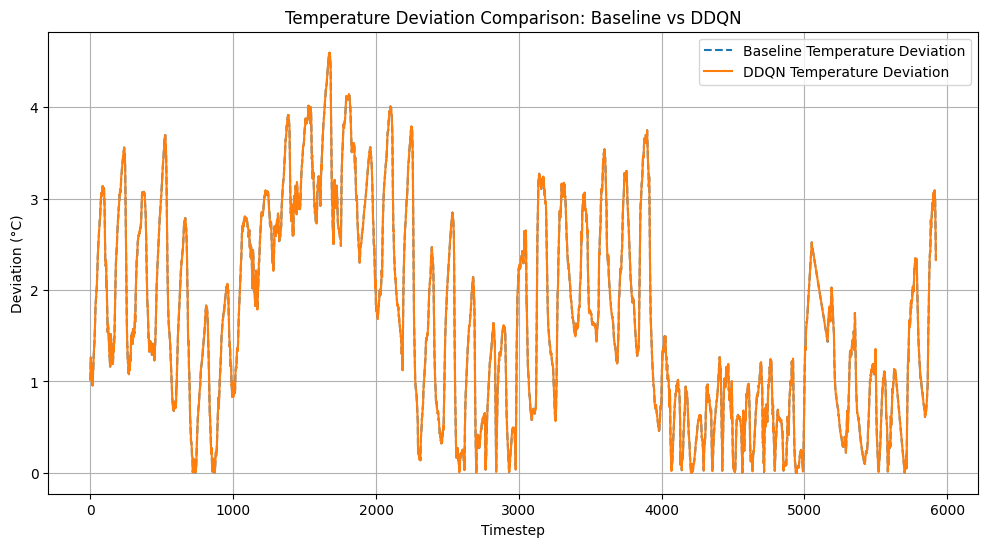

In [ ]:
# Section 9.5: Temperature Deviation Analysis

# 1. Collect baseline deviations
obs, done, baseline_wh = env_test.reset(), False, 0.0
baseline_deviations = []

while not done:
    avg_in_temp = obs[0]
    deviation = abs(avg_in_temp - env_test.desired_temp)
    baseline_deviations.append(deviation)

    action = 0  # baseline (no control)
    obs, _, done, _ = env_test.step(action)
    baseline_wh += env_test.thresholds[action]

# 2. Collect DDQN deviations
obs, done, rl_wh = env_test.reset(), False, 0.0
ddqn_deviations = []

while not done:
    avg_in_temp = obs[0]
    deviation = abs(avg_in_temp - env_test.desired_temp)
    ddqn_deviations.append(deviation)

    action, _ = model_ddqn.predict(obs, deterministic=True)
    obs, _, done, _ = env_test.step(action)
    rl_wh += env_test.thresholds[action]

# 3. Calculate Average Temperature Deviation
avg_baseline_td = sum(baseline_deviations) / len(baseline_deviations)
avg_ddqn_td = sum(ddqn_deviations) / len(ddqn_deviations)

# 4. Calculate Temperature Deviation Improvement
td_improvement = (avg_baseline_td - avg_ddqn_td) / avg_baseline_td * 100

# 5. Print Results
print(f"Average Baseline Temperature Deviation: {avg_baseline_td:.2f} °C")
print(f"Average DDQN Temperature Deviation: {avg_ddqn_td:.2f} °C")
print(f"Temperature Deviation Improvement: {td_improvement:.2f}%")

# 6. Plot Temperature Deviations
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(baseline_deviations, label='Baseline Temperature Deviation', linestyle='--')
plt.plot(ddqn_deviations, label='DDQN Temperature Deviation')
plt.xlabel('Timestep')
plt.ylabel('Deviation (°C)')
plt.title('Temperature Deviation Comparison: Baseline vs DDQN')
plt.legend()
plt.grid(True)
plt.show()


Results summary

In [ ]:
# Assuming you have baseline_wh and rl_wh already

# 1. Define cost per Wh (if not already)
cost_per_wh = 0.12  # (your electricity rate per Wh)

# 2. Calculate costs
baseline_cost = baseline_wh * cost_per_wh
rl_cost = rl_wh * cost_per_wh

# 3. Calculate savings
energy_saving = (baseline_wh - rl_wh) / baseline_wh
cost_saving = (baseline_cost - rl_cost) / baseline_cost

# 4. Print results
print(f"Energy Saving: {energy_saving * 100:.2f}%")
print(f"Cost Saving: {cost_saving * 100:.2f}%")

# 5. Now create the summary table
import pandas as pd

results_summary = {
    'Metric': ['Energy Saving (%)', 'Cost Saving (%)', 'Temperature Deviation Improvement (%)'],
    'Value': [
        energy_saving * 100,
        cost_saving * 100,
        td_improvement
    ]
}

summary_df = pd.DataFrame(results_summary)
summary_df['Value'] = summary_df['Value'].round(2)
print(summary_df.to_string(index=False))


Energy Saving: 89.26%
Cost Saving: 89.26%
                               Metric  Value
                    Energy Saving (%)  89.26
                      Cost Saving (%)  89.26
Temperature Deviation Improvement (%)   0.00
